# Parameter Estimation: Approximate Bayesian Computation

An exercise central to the study of infectious diseases is inference of epidemic parameters from incidence data.
In this chapter we demonstrate how PyGOM uses Approximate Bayesian Computation to offer estimates for parameters with credible intervals.

As an example, we use a synthetic data set produced by PyGOM's `solve_stochast <model_solver>` function.
This is a stochastic epidemic simulation of an SEIR model with parameters:

$\beta=0.35,\quad \alpha=0.5,\quad \gamma=0.25,\quad n_{\text{pop}}=10^4,\quad I(t=0)=5$

Loading in the data file

In [1]:
import numpy as np

out = np.loadtxt('seir_epi_data.txt')
t=out[:,0]
sol_i_r=out[:,1:3]

We inspect the time series of the infected and removed populations.

Text(0.5, 1.0, 'R')

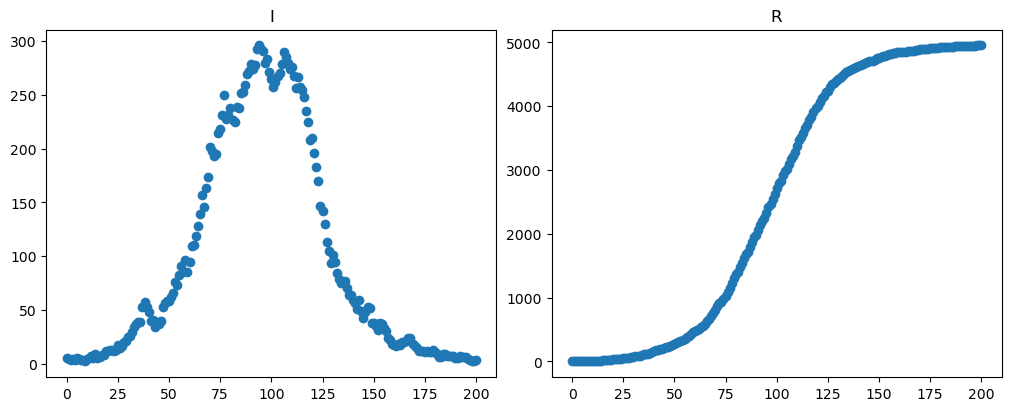

In [2]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 4]
f, axarr = plt.subplots(1,2, layout='constrained')
axarr[0].scatter(t, sol_i_r[:,0])
axarr[1].scatter(t, sol_i_r[:,1])
axarr[0].set_title('I')
axarr[1].set_title('R')

```{note}
We typically do not have access to information regarding the total infected population. More commonly reported is the number of new cases in a given time period (or infection times). Furthermore, we are unlikely to know the removed population, unless, for example, the disease results in death.

The purpose of this chapter is to demonstrate model fitting given a set of data and so these departures from reality shouldn't undermine the key messages.
```

In the next sections, we are going to use PyGOM to obtain estimates for unknown values $\beta$, $\alpha$ and $\gamma$ (assuming that the total population $N$ and initial number of infecteds $I(t=0)$ are known).

```{note}
Again, it is rather unrealistic to know $I(t=0)$ or $N$
```

## Fitting an SEIR model (with Infected and Removed known)

To obtain parameter estimates from data, we must provide a candidate model and specify the unknown parameters which we are interested in. Information regarding the candidate model is contained in `abc.create_loss()`, which requires:
1) A `SimulateOde` object which describes the system of ODE's
2) The loss function, which describes how we assume observations are distributed about the mean value (calculated via the `SimulateOde` object)
3) `abc.Parameter` which tells us which parameters we are interested in and their prior distributions.
4) The data to which we are fitting

We start by specifying the ODE system. In this first example, we are going to assume (correctly) that the underlying process is an SEIR model.
We need to let the model know the value of $N$, however, a feature of PyGOM is that we must pass values for all parameters.
This usually acts to ensure that we do not under-specify the set of parameters when running simulations.
Thus, even though the other parameters ($\beta$, $\alpha$ and $\gamma$) are unknown, the model expects some values and so for now we can just pass zeros, which will be overrode later when we specify ABC parameters.

In [12]:
# Set up pygom object from common models
from pygom import common_models

n_pop=1e4
paramEval=[('beta', 0), ('alpha', 0), ('gamma', 0), ('N', n_pop)]

ode_SEIR = common_models.SEIR_N_stochastic(param=paramEval)

The `Parameter` class is used to specify the parameters we wish to infer and their prior probability distributions.
We can choose from any of the distributions included in Pygom, here we use a uniform distribution.

In [10]:
from pygom import approximate_bayesian_computation as abc

parameters = [abc.Parameter('beta', 'unif', 0, 1, logscale=False),
              abc.Parameter('alpha', 'unif', 0, 2, logscale=False),
              abc.Parameter('gamma', 'unif', 0, 1, logscale=False)]

Finally, we must decide how observations are produced from the underlying model.
If we assume that each data point is the result of a random draw from a poisson process with mean equal to the SEIR model output at that timepoint, we use the option `PoissonLoss` as our loss function when calling `create_loss` below. Now we combine everything together, including the initial conditions which we are assuming are known.

In [5]:
i0=5
x0=[n_pop-i0, 0, i0, 0]

from pygom import PoissonLoss

objSEIR = abc.create_loss("PoissonLoss",         # Loss function
                          parameters,            # Unknown parameters and prior distributions
                          ode_SEIR,                   # Model
                          x0, t[0],              # Initial conditions and timepoints
                          t[1:], sol_i_r[1:,:],  # Data timepoints and I, R values
                          ['I', 'R'])            # Names of compartments in data

abcSEIR = abc.ABC(objSEIR, parameters)

A sequential Monte Carlo method (ABC-SMC) is used for param inference. This approach considers a series of generations, with each generation using a smaller threshold than the previous. The first generation is equivalent to the standard ABC algorithm, in the sense that parameters are sampled from prior distributions. In subsequent generations, candidate parameters are proposed by perturbing weighted samples from the previous generation. Here, we use a multivariate normal distribution with optimal local covariance matrix to perform the perturbation.

The ABC-SMC method requires a couple of additional arguments to `get_posterior_sample`:
- G - the number of generations
- q - a quantile (0 < q < 1). Whilst it is possible to specify a list of tolerances to use in each generation, it is difficult to know what these should be. When specifying q, the tolerance for the current generation is set to the q-th quantile of the distances from the previous generation. Larger values of q will result in smaller reductions in thresholds but a higher acceptance rate.

We run for 6 generations on our data

In [ ]:
import random
random.seed(1)

abcSEIR.get_posterior_sample(N=250, tol=np.inf, G=6, q=0.25, progress=True)

If we want to run the method for a few more generations, there is no need to start from the beginning. Instead, we can use `continue_posterior_sample` along with the `next_tol` attribute to set the tolerance. Let's perform 2 additional iterations.

In [ ]:
abcSEIR.continue_posterior_sample(N=250, tol=abcSEIR.next_tol, G=2, q=0.25, progress=True)

There are built in methods to plot the posterior distribution and the corresponding fit to the data 

In [ ]:
abcSEIR.plot_posterior_histograms();
abcSEIR.plot_pointwise_predictions();

The posterior draws are contained within `abcSIR.res`.
This can be useful if output needs to be saved, or for calculation credible intervals.

In [ ]:
print(f'beta={np.median(abcSEIR.res[:,0]):.3f} ({np.quantile(abcSEIR.res[:,0], 0.025):.3f}, {np.quantile(abcSEIR.res[:,0], 0.975):.3f})')
print(f'alpha={np.median(abcSEIR.res[:,1]):.3f} ({np.quantile(abcSEIR.res[:,1], 0.025):.3f}, {np.quantile(abcSEIR.res[:,1], 0.975):.3f})')
print(f'gamma={np.median(abcSEIR.res[:,2]):.3f} ({np.quantile(abcSEIR.res[:,2], 0.025):.3f}, {np.quantile(abcSEIR.res[:,2], 0.975):.3f})')

## Fitting an SEIR model (with only Infected known)

We now fit the same model, but assume we only have access to data concerning the infected component.
All that changes code-wise is that we omit the recovered time series when inputting the data and specify that we only have information for the infected population in the last argument of `create_loss`. We run the ABC algorithm for 8 generations.

Generation 1 
 tolerance = inf 
 acceptance rate = 70.42%

Generation 2 
 tolerance = 68844.11979 
 acceptance rate = 17.04%

Generation 3 
 tolerance = 12938.27625 
 acceptance rate = 16.18%

Generation 4 
 tolerance = 3996.71842 
 acceptance rate = 7.81%

Generation 5 
 tolerance = 1544.33260 
 acceptance rate = 5.69%

Generation 6 
 tolerance = 932.12762 
 acceptance rate = 4.59%

Generation 7 
 tolerance = 786.20244 
 acceptance rate = 4.26%

Generation 8 
 tolerance = 745.97669 
 acceptance rate = 9.37%



c:\users\joseph.gibson\pygom\pygom\approximate_bayesian_computation\approximate_bayesian_computation.py:556: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  f.show()
c:\users\joseph.gibson\pygom\pygom\approximate_bayesian_computation\approximate_bayesian_computation.py:634: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  f.show()


Posterior median estimates: beta=0.359, alpha=0.53, gamma=0.26 


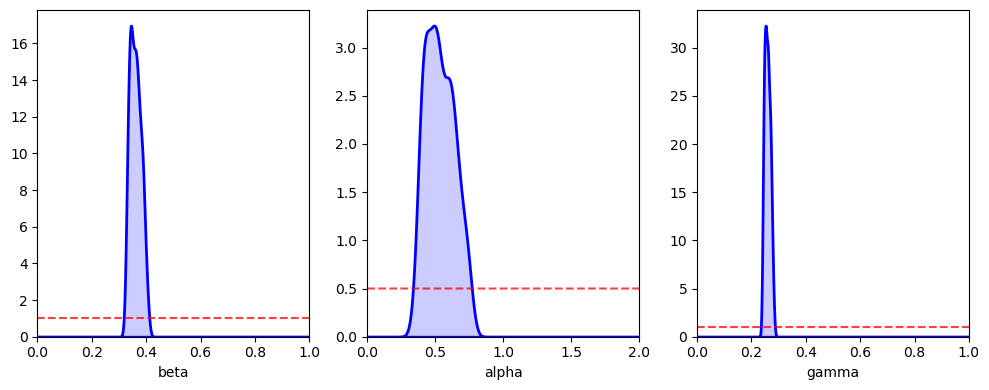

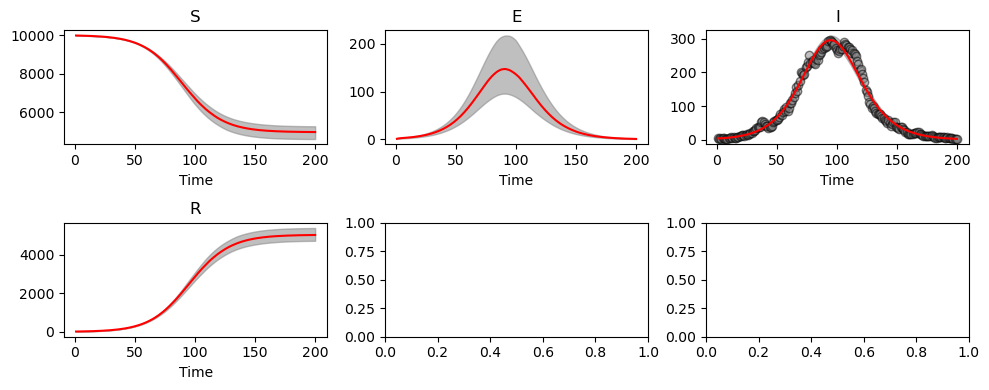

In [6]:
objSEIR2 = abc.create_loss("PoissonLoss",
                          parameters,
                          ode_SEIR,
                          x0, t[0],
                          t[1:], sol_i_r[1:,0],  # now we only pass one column of epi data
                          ['I'])                 # now we only have information regarding the infected compartment

abcSEIR2 = abc.ABC(objSEIR2, parameters)

abcSEIR2.get_posterior_sample(N=250, tol=np.inf, G=8, q=0.25, progress=True)
abcSEIR2.plot_posterior_histograms();
abcSEIR2.plot_pointwise_predictions();

In [9]:
print(f'beta={np.median(abcSEIR2.res[:,0]):.3f} ({np.quantile(abcSEIR2.res[:,0], 0.025):.3f}, {np.quantile(abcSEIR2.res[:,0], 0.975):.3f})')
print(f'alpha={np.median(abcSEIR2.res[:,1]):.3f} ({np.quantile(abcSEIR2.res[:,1], 0.025):.3f}, {np.quantile(abcSEIR2.res[:,1], 0.975):.3f})')
print(f'gamma={np.median(abcSEIR2.res[:,2]):.3f} ({np.quantile(abcSEIR2.res[:,2], 0.025):.3f}, {np.quantile(abcSEIR2.res[:,2], 0.975):.3f})')

beta=0.359 (0.330, 0.399)
alpha=0.526 (0.383, 0.740)
gamma=0.258 (0.242, 0.278)


We still see good estimates, even though we have constrained the model with one fewer state.

## Fitting an SIR model (with only Infected known)

Of course, we may not know the underlying mechanisms and might instead attempt to fit an SIR model to the infected data.


In [ ]:
parameters = [abc.Parameter('beta', 'unif', 0, 1, logscale=False),
              abc.Parameter('gamma', 'unif', 0, 1, logscale=False)]

# Params
paramEval=[('beta', 0), ('gamma', 0), ('N', n_pop)]

# Initial conditions now doen't require E0
x0=[n_pop-i0, i0, 0]

# Set up pygom object
ode_SIR = common_models.SIR_N_stochastic(param=paramEval)

objSIR = abc.create_loss("PoissonLoss", parameters, ode_SIR, x0, t[0], t[1:], sol_i_r[1:,0], ['I'])
abcSIR = abc.ABC(objSIR, parameters)

abcSIR.get_posterior_sample(N=250, tol=np.inf, G=8, q=0.25, progress=True)

abcSIR.plot_posterior_histograms();
abcSIR.plot_pointwise_predictions();

Although we see smaller CI's this actually reflects the difficulty in model fitting and is not an indication of precision.

In [ ]:
print(f'beta={np.median(abcSEIR.res[:,0]):.3f} ({np.quantile(abcSEIR.res[:,0], 0.025):.3f}, {np.quantile(abcSEIR.res[:,0], 0.975):.3f})')
print(f'gamma={np.median(abcSEIR.res[:,1]):.3f} ({np.quantile(abcSEIR.res[:,1], 0.025):.3f}, {np.quantile(abcSEIR.res[:,1], 0.975):.3f})')

## Initial conditions

In addition to inferring model parameters, the ABC methods can be used to estimate initial conditions, after all, it is unlikely that $I(t=0)$ is known with certainty.
To do this, the state that we wish to estimate the initial condition for should be included in the `parameters`:

In [16]:
parameters = [abc.Parameter('beta', 'unif', 0, 1, logscale=False),
              abc.Parameter('alpha', 'unif', 0, 2, logscale=False),
              abc.Parameter('gamma', 'unif', 0, 1, logscale=False),
              abc.Parameter('I', 'unif', 0, 20, logscale=False)]

The remaining code remains the same as before. Again we still need to pass variables even if they are unknown. In this case i0.

In [17]:
i0=5
x0=[n_pop-i0, 0, i0, 0]

objSEIR3 = abc.create_loss("PoissonLoss",
                          parameters,
                          ode_SEIR,
                          x0, t[0],
                          t[1:], sol_i_r[1:,0],  # now we only pass one column of epi data
                          ['I'])                 # now we only have information regarding the infected compartment

abcSEIR3 = abc.ABC(objSEIR3, parameters)

Generation 1 
 tolerance = inf 
 acceptance rate = 75.99%

Generation 2 
 tolerance = 56870.05009 
 acceptance rate = 13.30%

Generation 3 
 tolerance = 18012.48554 
 acceptance rate = 12.99%

Generation 4 
 tolerance = 4926.70805 
 acceptance rate = 6.67%

Generation 5 
 tolerance = 2036.33956 
 acceptance rate = 4.54%

Generation 6 
 tolerance = 1180.79752 
 acceptance rate = 2.87%

Generation 7 
 tolerance = 879.70651 
 acceptance rate = 1.33%

Generation 8 
 tolerance = 781.66943 
 acceptance rate = 0.70%



c:\users\joseph.gibson\pygom\pygom\approximate_bayesian_computation\approximate_bayesian_computation.py:556: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  f.show()
c:\users\joseph.gibson\pygom\pygom\approximate_bayesian_computation\approximate_bayesian_computation.py:634: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  f.show()


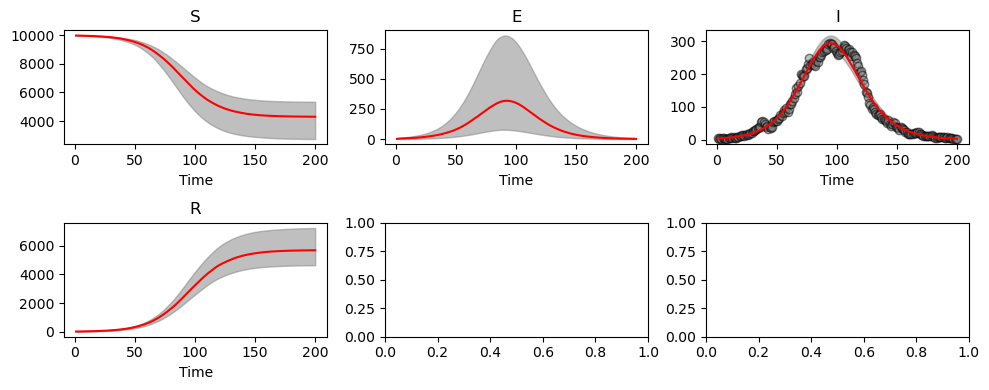

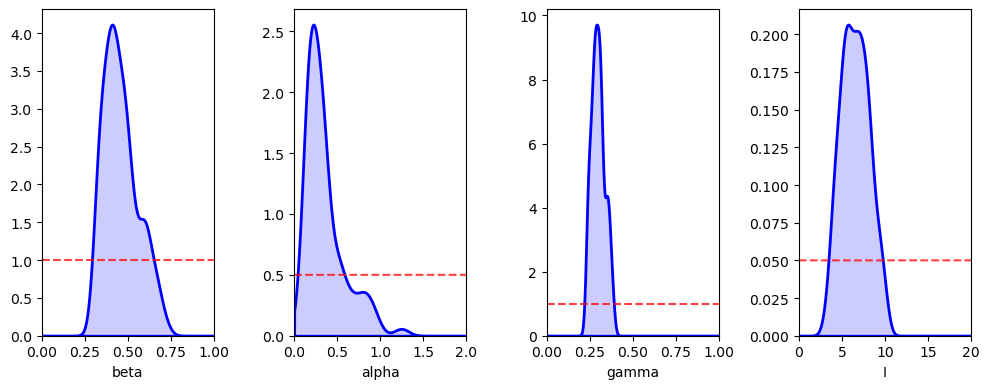

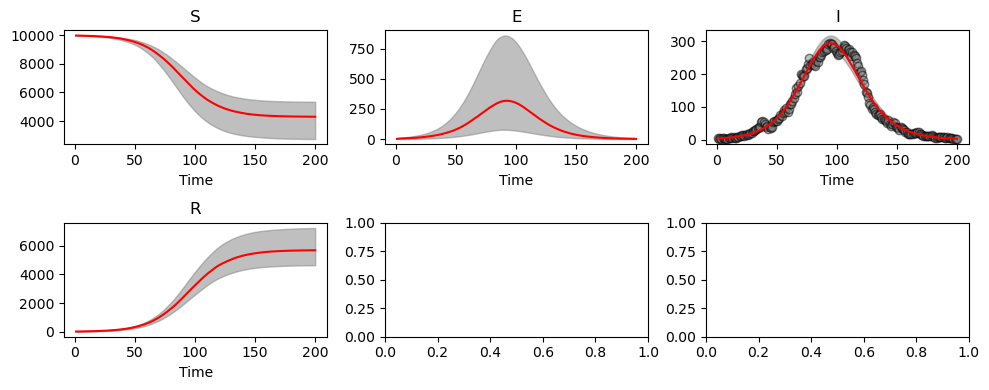

In [18]:
abcSEIR3.get_posterior_sample(N=250, tol=np.inf, G=8, q=0.25, progress=True)

abcSEIR3.plot_posterior_histograms();
abcSEIR3.plot_pointwise_predictions();

In [19]:
print(f'beta={np.median(abcSEIR3.res[:,0]):.3f} ({np.quantile(abcSEIR3.res[:,0], 0.025):.3f}, {np.quantile(abcSEIR3.res[:,0], 0.975):.3f})')
print(f'alpha={np.median(abcSEIR3.res[:,1]):.3f} ({np.quantile(abcSEIR3.res[:,1], 0.025):.3f}, {np.quantile(abcSEIR3.res[:,1], 0.975):.3f})')
print(f'gamma={np.median(abcSEIR3.res[:,2]):.3f} ({np.quantile(abcSEIR3.res[:,2], 0.025):.3f}, {np.quantile(abcSEIR3.res[:,2], 0.975):.3f})')
print(f'I0={np.median(abcSEIR3.res[:,3]):.3f} ({np.quantile(abcSEIR3.res[:,3], 0.025):.3f}, {np.quantile(abcSEIR3.res[:,3], 0.975):.3f})')

beta=0.439 (0.318, 0.673)
alpha=0.281 (0.129, 0.922)
gamma=0.295 (0.237, 0.375)
I0=6.472 (3.714, 9.692)
